# Attention! Warning! Use at your own risk!

If you are going to use pseudo labeling technique (which is used in this kernel) make sure you **understand what you are doing**. Otherwise you will **horribly overfit** to Public LB and will be shaken down on Private LB.

Thus you should not use this submission as is, but instead find a way to improve your model with this technique.

![](https://cdn1.imggmi.com/uploads/2019/6/4/52f979f0a731c7806f225c5b5cdc1b87-full.png)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from tqdm import tqdm_notebook
import warnings
import multiprocessing
warnings.filterwarnings('ignore')

Loading data with multiprocessing. Lets make those CPU cores work.

In [2]:
def load_data(data):
    return pd.read_csv(data)

with multiprocessing.Pool() as pool:
    train, test, sub = pool.map(load_data, ['../input/train.csv', '../input/test.csv', '../input/sample_submission.csv'])

Training first model with QDA, since it performs best on this dataset. We need predictions to make pseudo labeles furter on.

In [3]:
cols = [c for c in train.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic']]
oof = np.zeros(len(train))
preds = np.zeros(len(test))

for i in tqdm_notebook(range(512)):

    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)

    data = pd.concat([pd.DataFrame(train2[cols]), pd.DataFrame(test2[cols])])
    data2 = VarianceThreshold(threshold=2).fit_transform(data[cols])

    train3 = data2[:train2.shape[0]]; test3 = data2[train2.shape[0]:]

    skf = StratifiedKFold(n_splits=11, random_state=42)
    for train_index, test_index in skf.split(train2, train2['target']):

        clf = QuadraticDiscriminantAnalysis(0.6)
        clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof[idx1[test_index]] = clf.predict_proba(train3[test_index,:])[:,1]
        preds[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits

auc = roc_auc_score(train['target'], oof)
print(f'AUC: {auc:.5}')


AUC: 0.9649


Alright. By now we have predictions in *preds* variable. On some rows in test set model is pretty sure with its prediction, so some samples are predicted as 0.99999 and some as 0.00001. 

We assume that this is a correct case and simply label those samples as 1's and 0's respectively.

In [4]:
test['target'] = preds
test.loc[test['target'] > 0.99999, 'target'] = 1
test.loc[test['target'] < 0.00001, 'target'] = 0

Now we are adding this new marked samples to our training set. So next we will train on whole training set and a **part** of test set. This is where overfitting comes from.

In [5]:
usefull_test = test[(test['target'] == 1) | (test['target'] == 0)]
new_train = pd.concat([train, usefull_test]).reset_index(drop=True)

And the next model we are building is now training on this combined data.

In [6]:
oof = np.zeros(len(new_train))
preds = np.zeros(len(test))

for i in tqdm_notebook(range(512)):

    train2 = new_train[new_train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)

    data = pd.concat([pd.DataFrame(train2[cols]), pd.DataFrame(test2[cols])])
    data2 = VarianceThreshold(threshold=2).fit_transform(data[cols])

    train3 = data2[:train2.shape[0]]; test3 = data2[train2.shape[0]:]

    skf = StratifiedKFold(n_splits=15, random_state=42)
    for train_index, test_index in skf.split(train2, train2['target']):

        clf = QuadraticDiscriminantAnalysis(0.1)
        clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof[idx1[test_index]] = clf.predict_proba(train3[test_index,:])[:,1]
        preds[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits

auc = roc_auc_score(new_train['target'], oof)
print(f'AUC: {auc:.5}')


AUC: 0.97788


Edit: Fixed a problem with CV, which was incorrect because of pandas DataFrame indexes collisions.

In [7]:
sub['target'] = preds
sub.to_csv('submission.csv', index=False)

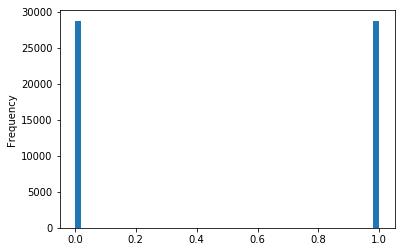

In [8]:
pd.Series(oof[-usefull_test.shape[0]:]).plot(kind='hist', bins=50)

In [9]:
auc = roc_auc_score(train['target'], oof[:-usefull_test.shape[0]])
print(f'AUC: {auc:.5}')

AUC: 0.96953


In [10]:
auc = roc_auc_score(new_train['target'].iloc[-usefull_test.shape[0]:], oof[-usefull_test.shape[0]:])
print(f'AUC: {auc:.5}')

AUC: 1.0


CV score of raw train data is 0.9695, CV score of the new_train data which is added in raw data is 1.0, PB score is 0.9681, the gap is acceptable, so i think there is no overfitting!